In [2]:
import os


os.environ['KAGGLE_API_TOKEN'] = 'KGAT_9961122a3f9b3f39bc3fb69666f3ce8'

!pip install -U -q kaggle


!kaggle datasets download -d erhmrai/ecg-image-data

!unzip -q ecg-image-data.zip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 146.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 19.4 MB/s eta 0:00:00
Dataset URL: https://www.kaggle.com/datasets/erhmrai/ecg-image-data
License(s): CC-BY-NC-SA-4.0
 99% 846M/858M [00:08<00:00, 136MB/s]
100% 858M/858M [00:08<00:00, 107MB/s]


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'ECG_Image_data'
if not os.path.exists(base_dir):
    base_dir = '.'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

print(f"Training directory found at: {train_dir}")
print(f"Testing directory found at: {test_dir}")


train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,


    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)


print("\n--- Loading Training Set (with Augmentation) ---")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("\n--- Loading Validation Set ---")
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("\n--- Loading Test Set ---")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n Done Augmentation ")

Training directory found at: ECG_Image_data/train
Testing directory found at: ECG_Image_data/test

--- Loading Training Set (with Augmentation) ---
Found 79362 images belonging to 6 classes.

--- Loading Validation Set ---
Found 19837 images belonging to 6 classes.

--- Loading Test Set ---
Found 24799 images belonging to 6 classes.

 Done Augmentation 


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers, regularizers

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False



model_vgg_regulated = models.Sequential([
    base_model,

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),

    layers.Dropout(0.5),

    layers.Dense(6, activation='softmax')
])

model_vgg_regulated.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model_vgg_regulated.summary()
print("---  تم بناء VGG16 المعدل (Anti-Overfitting) ---")

history_vgg_reg = model_vgg_regulated.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    verbose=1
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

--- 🚀 تم بناء VGG16 المعدل (Anti-Overfitting) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1185s 474ms/step - accuracy: 0.7753 - loss: 2.0231 - val_accuracy: 0.9303 - val_loss: 0.4322
Epoch 2/5
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1161s 468ms/step - accuracy: 0.9321 - loss: 0.4058 - val_accuracy: 0.9546 - val_loss: 0.2910
Epoch 3/5
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1134s 457ms/step - accuracy: 0.9535 - loss: 0.2900 - val_accuracy: 0.9655 - val_loss: 0.2305
Epoch 4/5
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1135s 458ms/step - accuracy: 0.9656 - loss: 0.2339 - val_accuracy: 0.9730 - val_loss: 0.1896
Epoch 5/5
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 1135s 457ms/step - accuracy: 0.9738 - loss: 0.1957 - val_accuracy: 0.9861 - val_loss: 0.1600


In [ ]:

model_vgg_regulated.save('ecg_vgg16_regulated.h5')
print("saved")

saved


In [4]:
from google.colab import files

print("dawnload(VGG16 Regulated)...")
files.download('ecg_vgg16_regulated.h5')

dawnload(VGG16 Regulated)...


FileNotFoundError: Cannot find file: ecg_vgg16_regulated.h5

In [6]:
from google.colab import files
import tensorflow as tf

print("uploading(ecg_vgg16_regulated.h5) ...")
uploaded = files.upload()


filename = 'ecg_vgg16_regulated.h5'
model_vgg_regulated = tf.keras.models.load_model(filename)

print("\n uploaded")

uploading(ecg_vgg16_regulated.h5) ...


Saving ecg_vgg16_regulated.h5 to ecg_vgg16_regulated.h5



 uploaded


---  testing ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


775/775 ━━━━━━━━━━━━━━━━━━━━ 145s 170ms/step

✅ final accurcy VGG16 : 98.34%
              precision    recall  f1-score   support

           F       0.00      0.00      0.00       161
           M       1.00      1.00      1.00      2101
           N       0.99      1.00      1.00     18926
           Q       0.94      0.99      0.96      1608
           S       0.77      0.80      0.79       556
           V       0.97      0.92      0.95      1447

    accuracy                           0.98     24799
   macro avg       0.78      0.78      0.78     24799
weighted avg       0.98      0.98      0.98     24799



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


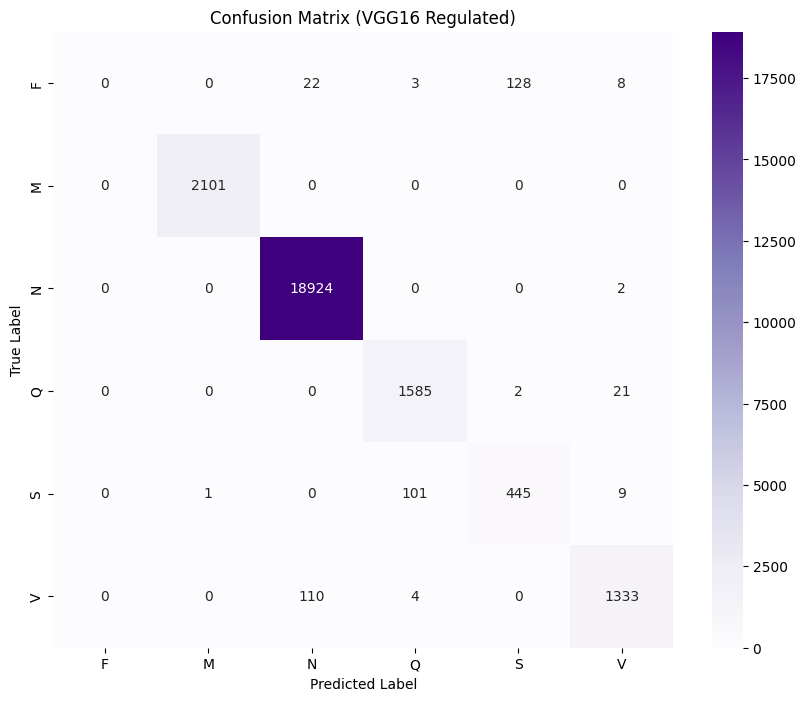

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("---  testing ---")


test_generator.reset()
predictions = model_vgg_regulated.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


from sklearn.metrics import accuracy_score
final_acc = accuracy_score(true_classes, predicted_classes)
print(f"\n✅ final accurcy VGG16 : {final_acc * 100:.2f}%")



print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (VGG16 Regulated)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()